### Recurrent memory intro

In the seminar you'll deploy recurrent neural network inside SARSA agent.

The environment it plays is a simple POMDP of rock-paper-scissors game with exploitable opponent.

#### Instructions

First, read through the code and __run it as you read__. The code will create a feedforward neural network and train it with SARSA.

Since the game is partially observable, default algorithm will won't reach optimal score. In fact, it's unstable and may even end up worse than random.

After you ran the code, __find the two ```#YOUR CODE HERE``` chunks__ (mb ctrl+f) and implement a recurrent memory.

Re-run the experiment and compare the performance of feedworward vs recurrent agent. 
RNN should be _much_ better, session __reward > 50__.

After you're done with that, proceed to the next part, for it is going to be much more interesting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 25

The environment we're going to use now is not a default gym env.

It was instead written from scratch in `rockpaperscissors.py`.

Morale: you can make your own gym environments easily with anything you want (including OS and the web, e.g. selenium)

In [2]:
import gym
from rockpaperscissors import RockPaperScissors
def make_env():
    env = RockPaperScissors()
    return gym.wrappers.TimeLimit(env,max_episode_steps=100)

#spawn game instance
env = make_env()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

env.reset()
obs = env.step(env.action_space.sample())[0]

print(obs)

[ 1.  0.  0.]


# Basic agent setup
Here we define a simple agent that maps game images into policy with a minimalistic neural net


In [3]:
#setup theano/lasagne. Prefer CPU
%env THEANO_FLAGS=device=gpu0,floatX=float32

import theano, lasagne
import theano.tensor as T
from lasagne.layers import *

env: THEANO_FLAGS=device=gpu0,floatX=float32


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-04-16 22:41:17,932] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 730M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5110)


In [55]:
#observation
obs = InputLayer((None,)+observation_shape,)
nn = DenseLayer(obs,32,nonlinearity=T.nnet.elu)

In [56]:
from agentnet.memory import RNNCell,GRUCell,LSTMCell
#YOUR CODE HERE:
#Implement a recurrent agent memory by un-comemnting code below and defining h_new

h_prev = InputLayer((None,50),name="previous memory state with 50 units")
h_new = DenseLayer(concat([h_prev, nn]), num_units=50, nonlinearity=T.nnet.elu)

nn = h_new

In [57]:
from agentnet.resolver import EpsilonGreedyResolver
l_qvalues = DenseLayer(nn,n_actions)
l_actions = EpsilonGreedyResolver(l_qvalues)

##### Agent, as usual

In [58]:
from agentnet.agent import Agent
#YOUR CODE HERE
#uncomment agent_states and define what layers should be used 

agent = Agent(observation_layers=obs,
              policy_estimators=(l_qvalues),
              agent_states={h_new: h_prev},
              action_layers=l_actions)

### Pool, as usual

In [59]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env,n_games=16 ) #may need to adjust

pool.update(SEQ_LENGTH)

### Learning

For N+1'st time, we use vanilla SARSA

In [60]:
replay = pool.experience_replay

qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
    unroll_scan=False, #this new guy makes compilation 100x faster for a bit slower runtime
)[-1]

auto_updates = agent.get_automatic_updates() #required if unroll_scan=False


In [61]:
# get SARSA mse loss
from agentnet.learning import sarsa
elemwise_mse = sarsa.get_elementwise_objective(qvalues_seq,
                                               actions=replay.actions[0],
                                               rewards=replay.rewards,
                                               is_alive=replay.is_alive)
loss = elemwise_mse.mean()

In [62]:
# Compute weights and updates
weights = lasagne.layers.get_all_params([l_actions], trainable=True)

updates = lasagne.updates.adam(loss, weights)

#compile train function
train_step = theano.function([],loss,updates=auto_updates+updates)

# Training loop

iter=10000,loss=0.526,epsilon=0.010
Episode finished after 100 timesteps with reward=71
Episode finished after 100 timesteps with reward=76
Episode finished after 100 timesteps with reward=78
Episode finished after 100 timesteps with reward=66
Episode finished after 100 timesteps with reward=68
Episode finished after 100 timesteps with reward=81
Episode finished after 100 timesteps with reward=72
Episode finished after 100 timesteps with reward=72
Episode finished after 100 timesteps with reward=64
Episode finished after 100 timesteps with reward=78


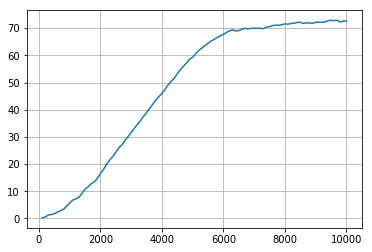

100%|██████████| 10000/10000 [11:59<00:00, 13.89it/s]


In [63]:
from tqdm import trange
from IPython.display import clear_output

#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}
loss,reward = 0, 0
for i in trange(10000):    
    
    #play
    pool.update(SEQ_LENGTH)
    #train
    loss=train_step()
    
    #update epsilon
    new_epsilon = max(0.01,1-2e-4*epoch_counter)
    l_actions.epsilon.set_value(np.float32(new_epsilon))
    
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 == 0:
        clear_output(True)
        print("iter=%i,loss=%.3f,epsilon=%.3f"%(epoch_counter,loss,new_epsilon))
        reward = 0.9*reward + 0.1*np.mean(np.mean(pool.evaluate(save_path="./records",n_games=10,
                                                                  record_video=False,use_monitor=False)))
        rewards[epoch_counter] = reward
        
        plt.plot(*zip(*sorted(rewards.items(),key=lambda t:t[0])))
        plt.grid()
        plt.show()
        
    epoch_counter  += 1

# Evaluating results
 * Here we plot learning curves and sample testimonials

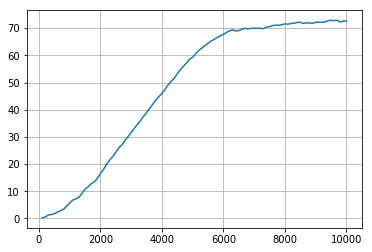

In [64]:
plt.plot(*zip(*sorted(rewards.items(),key=lambda k:k[0])))
plt.grid()

## Bonus (1++ points)

Compare two types of nonlinearities for the RNN:
- `T.nnet.elu`
- `T.nnet.sigmoid`

Re-train agent at least 10 times. It's probably a good idea to automate the process.

Notice something weird? Any clue why this happens and how to fix it?

_Running the experiment and reporting results gets your 1 point. Reward will get much higher as you go down the rabbit hole! Don't forget to send this notebook to anytask and mention that you went for this bonus._

In [1]:
#results, ideas, solutions...

```


```
```


```
```


```
```


```
```


```
```


```
```


```
```


```
```


```
```


```
```


```
